# Building a Chatbot Agent in LangGraph

In this tutorial, we will build a support chatbot using LangGraph. We will implement this chatbot via a graph workflow using nodes and edges.

The chatbot will:

- Answer common questions by searching the web.
- Use custom tools to enhance its capabilities.
- Maintain conversation state across calls.

This tutorial builds the foundation for more complex workflows and design patterns later in the course.

### Imports
We start by importing the necessary libraries:

In [6]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from datetime import datetime
from typing import Annotated
from typing_extensions import TypedDict

from dotenv import load_dotenv
_ = load_dotenv()

### Defining the Model
Initialize the language model:

In [7]:
llm = ChatOpenAI(model="gpt-4o")

### Defining the Tools
We will define two tools:

- Tavily Search Tool: To fetch relevant information from the web.
- Current Date and Time Tool: Helps the chatbot respond to time-based queries.


In [8]:
# Tavily Search Tool
tavily_search = TavilySearchResults(max_results=2)

# Current Date and Time Tool
@tool
def get_current_date():
    """Returns the current date and time. Use this tool first for any time-based queries."""
    return f"The current date is: {datetime.now().strftime('%d %B %Y')}"

In [9]:
# list of tools for the agent
tools = [tavily_search, get_current_date]

### Defining the StateGraph
We define the state of our chatbot using StateGraph. The State consists of a messages list, which will store the conversation history.


In [10]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Binding Tools to the LLM
We bind the tools to the language model:

In [5]:
llm_with_tools = llm.bind_tools(tools)

### Defining the Graph Nodes
We define a chatbot node, which represents the LLM's response generation. We also define a tool node to handle tool calls.

In [11]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [12]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

### Defining the Graph Edges
We define how the chatbot transitions between nodes:

In [13]:
# Conditional edge to decide whether to use tools, this is a prebuilt conditional edge
graph_builder.add_conditional_edges("chatbot", tools_condition)

# If tools are used, return to the chatbot to process the tool output
graph_builder.add_edge("tools", "chatbot")

# Set the entry point of the graph
graph_builder.set_entry_point("chatbot")

### Compiling the Graph
We compile the graph to create a runnable chatbot:

In [16]:
graph = graph_builder.compile()

### Visualizing the Chatbot's Workflow
We can visualize the chatbot's workflow using LangGraph's graph visualization tools:

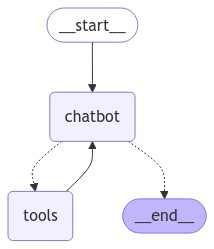

In [17]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Chatbot
Now, we can interact with our chatbot.

#### Helper Functions
We define helper functions to process and render the chatbot's responses:

In [18]:
from IPython.display import Markdown, display

def render_markdown(md_string):
    display(Markdown(md_string))

def process_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
    return message

def process_query(query, config=None):
    inputs = {"messages": [("user", query)]}
    message = process_stream(graph.stream(inputs, config, stream_mode="values"))
    render_markdown(f"## Answer:\n{message.content}")


#### Testing the Chatbot
We can now test the chatbot with various queries:

In [19]:
process_query("Hello! What can you do?")

================================ Human Message =================================

Hello! What can you do?
================================== Ai Message ==================================

Hello! I can assist you with a variety of tasks, including:

1. **Answering Questions**: Whether it's general knowledge or specific topics, feel free to ask!
2. **Providing Current Information**: I can look up current events, news, and other timely information.
3. **Time and Date Queries**: I can tell you the current time and date.
4. **Search**: I can perform searches to find information on a wide range of topics.

If there's anything specific you'd like help with, just let me know!


## Answer:
Hello! I can assist you with a variety of tasks, including:

1. **Answering Questions**: Whether it's general knowledge or specific topics, feel free to ask!
2. **Providing Current Information**: I can look up current events, news, and other timely information.
3. **Time and Date Queries**: I can tell you the current time and date.
4. **Search**: I can perform searches to find information on a wide range of topics.

If there's anything specific you'd like help with, just let me know!

In [20]:
# Query that requires current date
process_query("What is the current date?")

================================ Human Message =================================

What is the current date?
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_AEVJxkXDagKxvILm29YDOwPb)
 Call ID: call_AEVJxkXDagKxvILm29YDOwPb
  Args:
================================= Tool Message =================================
Name: get_current_date

The current date is: 13 October 2024
================================== Ai Message ==================================

Today's date is October 13, 2024.


## Answer:
Today's date is October 13, 2024.

In [21]:
# Query that triggers the Tavily search tool
process_query("What is LangGraph?")

================================ Human Message =================================

What is LangGraph?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Z4bKvtOuM7taoliLy2tg2hrl)
 Call ID: call_Z4bKvtOuM7taoliLy2tg2hrl
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a low-level framework that allows you to create stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph

## Answer:
LangGraph is a low-level framework designed for creating stateful, multi-actor applications using Large Language Models (LLMs). It focuses on features such as cycles, controllability, and persistence. LangGraph can be used in conjunction with tools like LangChain, LangSmith, and Anthropic to build agent and multi-agent workflows. For more detailed information, you can visit the [LangGraph documentation](https://langchain-ai.github.io/langgraph/) or check out its [GitHub repository](https://github.com/langchain-ai/langgraph).

In [23]:
# Time-based query about an event
process_query("When is the next olympics?")

================================ Human Message =================================

When is the next olympics?
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_gYV0h2obitM3FQt6LImpDBBE)
 Call ID: call_gYV0h2obitM3FQt6LImpDBBE
  Args:
================================= Tool Message =================================
Name: get_current_date

The current date is: 13 October 2024
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_FJ2f0fsiZhPwy8sjEyj5oeHx)
 Call ID: call_FJ2f0fsiZhPwy8sjEyj5oeHx
  Args:
    query: next Olympics date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://olympics.com/ioc/faq/future-olympic-games/where-will-the-next-olympic-games-be-held", "content": "Future Olympic Games. Where will the next Olympic Games be held? In Milan and Cortina d'Ampezz

## Answer:
The next Olympic Games are the Winter Olympics, which will be held in Milan and Cortina d'Ampezzo, Italy, from February 6 to February 22, 2026.

## Need for Memory

Taking a look at an example of where the current chatbot falls short when remembering previous interactions.

In [24]:
process_query("Hi. My name is Sajal. Who are you?")

================================ Human Message =================================

Hi. My name is Sajal. Who are you?
================================== Ai Message ==================================

Hello Sajal! I'm an AI assistant here to help you with information, answer questions, and assist with various tasks. If there's anything specific you'd like to know or do, feel free to ask!


## Answer:
Hello Sajal! I'm an AI assistant here to help you with information, answer questions, and assist with various tasks. If there's anything specific you'd like to know or do, feel free to ask!

In [25]:
process_query("What is my name?")

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm sorry, but I don't have access to personal data about you, including your name. If you have any questions or need assistance, feel free to let me know!


## Answer:
I'm sorry, but I don't have access to personal data about you, including your name. If you have any questions or need assistance, feel free to let me know!

### Adding Memory to the Chatbot
To maintain conversation state across calls, we use LangGraph's checkpointing system.

#### Setting Up Checkpointing
We create a MemorySaver checkpointer:

In [26]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [27]:
# Compile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=memory)

#### Using Thread IDs for Conversation State
We can maintain separate conversation threads by providing a thread_id in the configuration:

In [29]:
config_user_1 = {"thread_id": "user_1"}
process_query("Hi. My name is Sajal. Who are you?", config=config_user_1)

================================ Human Message =================================

Hi. My name is Sajal. Who are you?
================================== Ai Message ==================================

Hello Sajal! I'm an AI designed to assist with a wide range of questions and tasks. How can I help you today?


## Answer:
Hello Sajal! I'm an AI designed to assist with a wide range of questions and tasks. How can I help you today?

In [30]:
process_query("What is my name?", config=config_user_1)

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Sajal.


## Answer:
Your name is Sajal.

In [31]:
# Checking if memory is shared across threads
config_user_2 = {"thread_id": "user_2"}
process_query("What is my name?", config=config_user_2)

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm sorry, but I don't have access to personal data about users unless it has been shared with me in the course of our conversation. If you tell me your name, I can remember it for the duration of our chat.


## Answer:
I'm sorry, but I don't have access to personal data about users unless it has been shared with me in the course of our conversation. If you tell me your name, I can remember it for the duration of our chat.